In [1]:
import tensorflow as tf
print("Hello!", tf.__version__)

Hello! 2.13.0


In [2]:
# 2. 필요한 라이브러리 설치 및 임포트
# # 필요 라이브러리 설치 코드 (설치 안 된 경우에만 설치되도록 구성)
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 설치할 패키지 목록
required_packages = [
    "librosa",
    "matplotlib",
    "numpy",
    "pandas",
    "scikit-learn",
    "tensorflow==2.13"
]

for pkg in required_packages:
    try:
        __import__(pkg.split("==")[0])
    except ImportError:
        install(pkg)

# # 임포트 코드
import os
import json
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# Focal Loss 정의 함수
def focal_loss(gamma=1.5, alpha=0.3):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1. - 1e-8)  # log 안정성 확보
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

In [4]:
# 3. 오디오 및 라벨 경로 설정
label_dir = "D:/machinelearning_task/label_data/indoor"
audio_dir = "D:/machinelearning_task/audio_data/indoor"

In [5]:
# 4. 오디오 파일과 라벨 매칭 및 데이터 준비
def extract_emotion_label(json_path):
    with open(json_path, encoding='utf-8') as f:
        data = json.load(f)
    file_name = data.get("File", {}).get("FileName", None)
    conv = data.get("Conversation", [])

    # 대화 내에서 감정 정보가 있는 항목 탐색
    for turn in conv:
        emotion = turn.get("SpeakerEmotionCategory", None)
        if file_name and emotion:
            return file_name + ".wav", emotion
    return None, None

file_labels = []
for fname in os.listdir(label_dir):
    if fname.endswith(".json"):
        wav_name, emotion = extract_emotion_label(os.path.join(label_dir, fname))
        if wav_name and emotion:
            file_labels.append((wav_name, emotion))

df = pd.DataFrame(file_labels, columns=["filename", "emotion"])
print(df.head())

                                            filename emotion
0  2_0001G2A3_0005G2A6_T1_2D06T0219C000451_000112...      긍정
1  2_0002G2A3_0003G2A5_T1_2D01T0030C000132_000323...      긍정
2  2_0002G2A3_0003G2A5_T1_2D01T0042C000171_000324...      긍정
3  2_0002G2A3_0003G2A5_T1_2D02T0058C000224_000309...      긍정
4  2_0002G2A3_0003G2A5_T1_2D02T0065C000405_000351...      긍정


In [6]:
def augment_audio(y, sr):
    y_stretch = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))
    y_shift = librosa.effects.pitch_shift(y_stretch, sr=sr, n_steps=np.random.randint(-2, 2))
    noise = np.random.normal(0, 0.005, size=y_shift.shape)
    y_noisy = y_shift + noise
    return y_noisy

In [7]:
# 5. 멜 스펙트로그램으로 오디오 전처리
def extract_audio_features(audio_path, sr=22050, duration=3, offset=0.5):
    try:
        y, sr = librosa.load(audio_path, sr=sr, duration=duration, offset=offset)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # 시간 축 기준으로 padding 또는 trimming
        mel = librosa.util.fix_length(mel, size=128, axis=1)
        chroma = librosa.util.fix_length(chroma, size=128, axis=1)
        contrast = librosa.util.fix_length(contrast, size=128, axis=1)

        features = np.vstack([mel, chroma, contrast])
        return features
    except Exception as e:
        print(f"Error with {audio_path}: {e}")
        return None

def extract_audio_features_from_wave(y, sr):
    try:
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        mel = librosa.util.fix_length(mel, size=128, axis=1)
        chroma = librosa.util.fix_length(chroma, size=128, axis=1)
        contrast = librosa.util.fix_length(contrast, size=128, axis=1)

        features = np.vstack([mel, chroma, contrast])
        return features
    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None

X, y = [], []
for i, row in df.iterrows():
    wav_path = os.path.join(audio_dir, row["filename"])
    try:
        y_raw, sr = librosa.load(wav_path, sr=22050, duration=3, offset=0.5)
        emotion = row["emotion"]

        # 원본 추가
        feat_orig = extract_audio_features_from_wave(y_raw, sr)
        if feat_orig is not None:
            X.append(feat_orig)
            y.append(emotion)

        # 부정 감정만 증강 3배, 나머지는 1번
        aug_n = 3 if emotion == "부정" else 1

        for _ in range(aug_n):
            y_aug = augment_audio(y_raw, sr)
            feat_aug = extract_audio_features_from_wave(y_aug, sr)
            if feat_aug is not None:
                X.append(feat_aug)
                y.append(emotion)

    except Exception as e:
        print(f"Error processing {row['filename']}: {e}")

        # X, y에 데이터 다 넣은 후
print("데이터 수 확인 전:")
print(len(X), len(y))

from collections import Counter
label_counts = Counter(y)
print("감정별 데이터 개수:")
for label, count in label_counts.items():
    print(f"- {label}: {count}개")


X = np.array(X)
X = X[..., np.newaxis]  # CNN 입력을 위한 채널 차원 추가
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


데이터 수 확인 전:
2298 2298
감정별 데이터 개수:
- 긍정: 1488개
- 중립: 362개
- 부정: 448개
X shape: (2298, 83, 128, 1)
y shape: (2298, 3)


In [8]:
# 6. 훈련/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# 클래스 가중치 계산
y_integers = np.argmax(y, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights = dict(enumerate(class_weights))

In [10]:
# 7. CNN 모델 정의
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:]),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 81, 126, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 81, 126, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 40, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 38, 61, 64)        2

In [11]:
# 8. 모델 훈련
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), class_weight=class_weights, callbacks=[early_stop])

Epoch 1/50
115/115 [==============================] - 29s 224ms/step - loss: 0.0957 - accuracy: 0.5778 - val_loss: 0.0380 - val_accuracy: 0.6152
Epoch 2/50
115/115 [==============================] - 25s 215ms/step - loss: 0.0368 - accuracy: 0.6507 - val_loss: 0.0343 - val_accuracy: 0.6174
Epoch 3/50
115/115 [==============================] - 25s 217ms/step - loss: 0.0347 - accuracy: 0.6551 - val_loss: 0.0343 - val_accuracy: 0.6174
Epoch 4/50
115/115 [==============================] - 25s 216ms/step - loss: 0.0340 - accuracy: 0.6545 - val_loss: 0.0339 - val_accuracy: 0.6174
Epoch 5/50
115/115 [==============================] - 25s 216ms/step - loss: 0.0336 - accuracy: 0.6556 - val_loss: 0.0346 - val_accuracy: 0.6174
Epoch 6/50
115/115 [==============================] - 25s 222ms/step - loss: 0.0328 - accuracy: 0.6561 - val_loss: 0.0335 - val_accuracy: 0.6174
Epoch 7/50
115/115 [==============================] - 25s 216ms/step - loss: 0.0321 - accuracy: 0.6551 - val_loss: 0.0333 - val_ac

15/15 [==============================] - 1s 68ms/step - loss: 0.0330 - accuracy: 0.6174
Test Accuracy: 0.6174


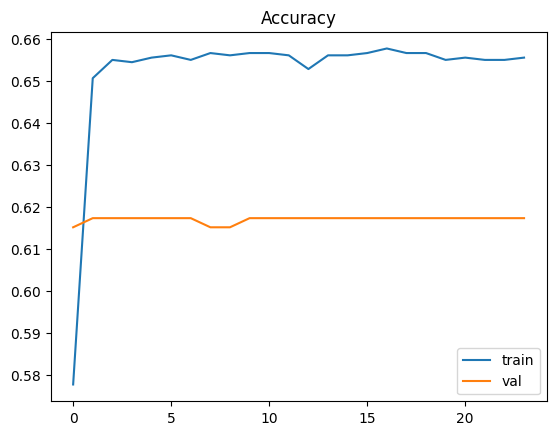

In [12]:
# 9. 평가 및 시각화
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Accuracy")
plt.show()

15/15 [==============================] - 1s 67ms/step


c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 47549 (\N{HANGUL SYLLABLE RIB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 445

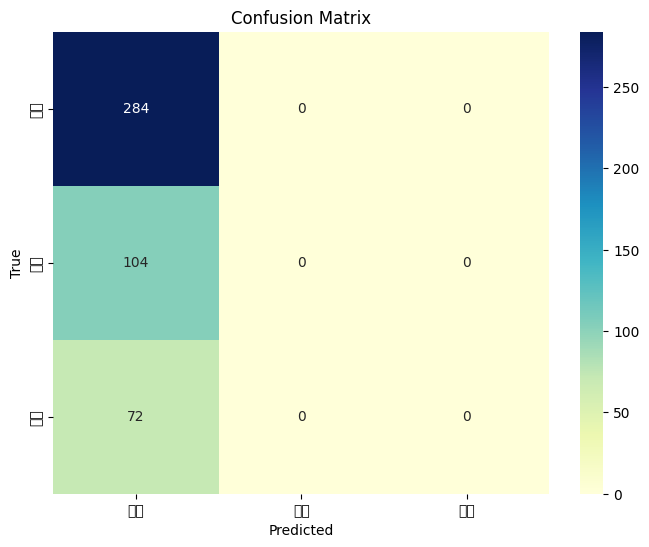

Classification Report:

              precision    recall  f1-score   support

          긍정       0.62      1.00      0.76       284
          부정       0.00      0.00      0.00       104
          중립       0.00      0.00      0.00        72

    accuracy                           0.62       460
   macro avg       0.21      0.33      0.25       460
weighted avg       0.38      0.62      0.47       460



c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nh\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [15]:
!pip install seaborn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 예측
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# 라벨 디코딩
labels = le.classes_

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='YlGnBu')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 정밀도/재현율/정확도 등
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))